In [1]:
# download and install the code

%%bash

git clone -b dev https://github.com/katherinekarababas/sodapop-em.git #download code repository from my GitHub account 
# can remove the -b dev option; just grabbing the dev branch for now because it's got some example data

mkdir /opt/bin /opt/lib/ /opt/lib/python3.7 /opt/lib/python3.7/site-packages #create install directory and make it findable
export PATH=$PATH:/opt/bin
export PYTHONPATH=$PYTHONPATH:/opt/lib/python3.7/site-packages

cd sodapop-em #install code
python3 setup.py install --prefix /opt/

python3 -m pip install emcee #install emcee package to handle markov-chain monte carlo sampling

echo -e '\n *** \n'

sample-pop-params -h #executable that draws samples in the population model's parameters

echo -e '\n *** \n'

infer-pop-params -h #executable that calculates the posterior probability of the sampled population parameters

echo -e '\n *** \n'

build-ppd -h #executable that postprocesses the population posterior samples to calculate the inferred mass distribution

echo -e '\n *** \n'

running install
running bdist_egg
running egg_info
creating sodapop.egg-info
writing sodapop.egg-info/PKG-INFO
writing dependency_links to sodapop.egg-info/dependency_links.txt
writing top-level names to sodapop.egg-info/top_level.txt
writing manifest file 'sodapop.egg-info/SOURCES.txt'
writing manifest file 'sodapop.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/sodapop
copying sodapop/priors.py -> build/lib/sodapop
copying sodapop/__init__.py -> build/lib/sodapop
copying sodapop/diagnostics.py -> build/lib/sodapop
copying sodapop/select.py -> build/lib/sodapop
copying sodapop/populations.py -> build/lib/sodapop
copying sodapop/emcee.py -> build/lib/sodapop
copying sodapop/parameters.py -> build/lib/sodapop
creating build/bdist.linux-x86_64
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/sodapop
copying build/lib/sodapop/priors.py -> buil

Cloning into 'sodapop-em'...
zip_safe flag not set; analyzing archive contents...


In [2]:
# run this cell to pull updates without re-downloading the whole repo

%%bash

cd sodapop-em
git pull 
python3 setup.py install --prefix /opt/

Already up to date.
running install
Checking .pth file support in /opt//lib/python3.7/site-packages/
/usr/bin/python3 -E -c pass
running bdist_egg
running egg_info
writing sodapop.egg-info/PKG-INFO
writing dependency_links to sodapop.egg-info/dependency_links.txt
writing top-level names to sodapop.egg-info/top_level.txt
writing manifest file 'sodapop.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/sodapop
copying build/lib/sodapop/priors.py -> build/bdist.linux-x86_64/egg/sodapop
copying build/lib/sodapop/__init__.py -> build/bdist.linux-x86_64/egg/sodapop
copying build/lib/sodapop/diagnostics.py -> build/bdist.linux-x86_64/egg/sodapop
copying build/lib/sodapop/select.py -> build/bdist.linux-x86_64/egg/sodapop
copying build/lib/sodapop/populations.py -> build/bdist.linux-x86_64/egg/sodapop
copying build/lib/sodapop/emcee.py -> build/bdist.linux-

TEST FAILED: /opt//lib/python3.7/site-packages/ does NOT support .pth files
bad install directory or PYTHONPATH

You are attempting to install a package to a directory that is not
on PYTHONPATH and which Python does not read ".pth" files from.  The
installation directory you specified (via --install-dir, --prefix, or
the distutils default setting) was:

    /opt//lib/python3.7/site-packages/

and your PYTHONPATH environment variable currently contains:

    '/env/python'

Here are some of your options for correcting the problem:

* You can choose a different installation directory, i.e., one that is
  on PYTHONPATH or supports .pth files

* You can add the installation directory to the PYTHONPATH environment
  variable.  (It must then also be on PYTHONPATH whenever you run
  Python and want to use the package(s) you are installing.)

* You can set up the installation directory to support ".pth" files by
  using one of the approaches described here:

  https://setuptools.readthedocs.io/

In [2]:
# import packages

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import interp1d
import numpy.random

In [3]:
# load posterior predictive distribution

joint_path = 'sodapop-em/dat/gw+dns/peakcut_mass_ppd.csv' # modify path as needed to point to results

joint_data = np.genfromtxt(joint_path,delimiter=',',names=True,dtype=None) # read csv file

In [4]:
# build a binary mass model from ppd

joint_ppd = interp1d(joint_data['m'],joint_data['med']) # interpolate mass distribution function p(m) from ppd data

def joint_m1m2_ppd(m1,m2): # binary mass distribution is just p(m1)*p(m2), subject to m1 >= m2

  return np.where(m1 >= m2, joint_ppd(m1)*joint_ppd(m2), 0.) # if condition satisfied, returns first expression, else second

In [5]:
# draw samples from the binary mass model

num_grid = 10000
mAs = np.random.uniform(1.,3.,num_grid) # sample uniformly in m1 and m2, subject to m1 >= m2
mBs = np.random.uniform(1.,3.,num_grid)
m1s = np.array([max(mA,mB) for mA,mB in zip(mAs,mBs)])
m2s = np.array([min(mA,mB) for mA,mB in zip(mAs,mBs)])

mass_wts = joint_m1m2_ppd(m1s,m2s) # then weight the uniform samples by the binary mass model
select_wts = ((m1s*m2s)**0.6/(m1s+m2s)**0.2)**2.5 # also weight them by the gravitational wave selection function (chirp mass)^5/2, i.e. by how likely they are to be observed
wts = mass_wts*select_wts

num_samps = 1000
idxs = np.random.choice(range(num_grid),num_samps,True,wts/np.sum(wts))
m1s_obs = m1s[idxs]
m2s_obs = m2s[idxs]

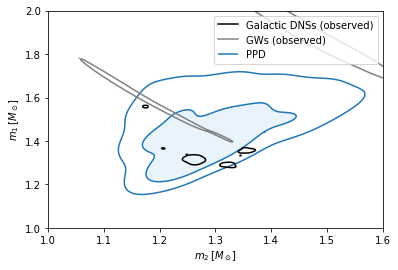

In [23]:
# plot posterior predictive check using seaborn kdeplot; see the docs at https://seaborn.pydata.org/generated/seaborn.kdeplot.html

fig = sns.kdeplot(x=m2s_obs,y=m1s_obs, levels=[0.1,0.5], label='PPD') # predicted distribution of observations
sns.kdeplot(x=m2s_obs,y=m1s_obs, levels=[0.5,1.], fill=True, alpha=0.1, color=sns.color_palette()[0]) # just filling the inner contours

dns_path = 'sodapop-em/etc/dns/' # load observations to compare; modify paths as needed
gw_path = 'sodapop-em/etc/gw/'

dns1_names = ['psr_B1534+12.csv', 'psr_B1913+16.csv', 'psr_B2127+11C.csv', 'psr_J0453+1559.csv', 'psr_J0737-3039A.csv', 'psr_J1756-2251.csv',
'psr_J1807-2500B.csv', 'psr_J1906+0746.csv']

dns2_names = ['psr_B1534+12_comp.csv', 'psr_B1913+16_comp.csv', 'psr_B2127+11C_comp.csv', 'psr_J0453+1559_comp.csv', 'psr_J0737-3039B.csv', 'psr_J1756-2251_comp.csv',
'psr_J1807-2500B_comp.csv', 'psr_J1906+0746_comp.csv']
gw_names = ['GW170817_reweighted.csv','GW190425_reweighted.csv']

for dns1,dns2 in zip(dns1_names,dns2_names): # pair up the dns primaries and secondaries to show on m1-m2 plot
  dns1_data = np.genfromtxt(dns_path+dns1,delimiter=',',names=True,dtype=None)
  dns2_data = np.genfromtxt(dns_path+dns2,delimiter=',',names=True,dtype=None)
  likes = dns1_data['likelihood']*dns2_data['likelihood'] # binary likelihood is just product of likelihoods
  sns.kdeplot(x=dns2_data['m'],y=dns1_data['m'],weights=likes,levels=[0.5,1.],color='k') # plot the 50% credible region for each observation

for gw in gw_names:
  gw_data = np.genfromtxt(gw_path+gw,delimiter=',',names=True,dtype=None)
  likes = gw_data['likelihood']
  sns.kdeplot(x=gw_data['m2_source'],y=gw_data['m1_source'],weights=likes,levels=[0.5,1.],color='grey') # instead of contours, could experiment with putting a scatter point at the m1-m2 pair of greatest likelihood

plt.xlabel(r'$m_2 \,[M_\odot]$')
plt.ylabel(r'$m_1 \,[M_\odot]$')

plt.xlim(1.,1.6)
plt.ylim(1.,2.)

plt.plot([-1.,-1.],[-1.,-1.],label='Galactic DNSs (observed)', color='k') # hack to add a legend entry
plt.plot([-1.,-1.],[-1.,-1.],label='GWs (observed)', color='grey')
plt.legend()
plt.show()